In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [29]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-03-09 20:42:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   216MB/s    in 0.3s    

2024-03-09 20:42:03 (216 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [30]:
import os
import zipfile

local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [32]:
data_dir = './cats_and_dogs_filtered'

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.


In [49]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


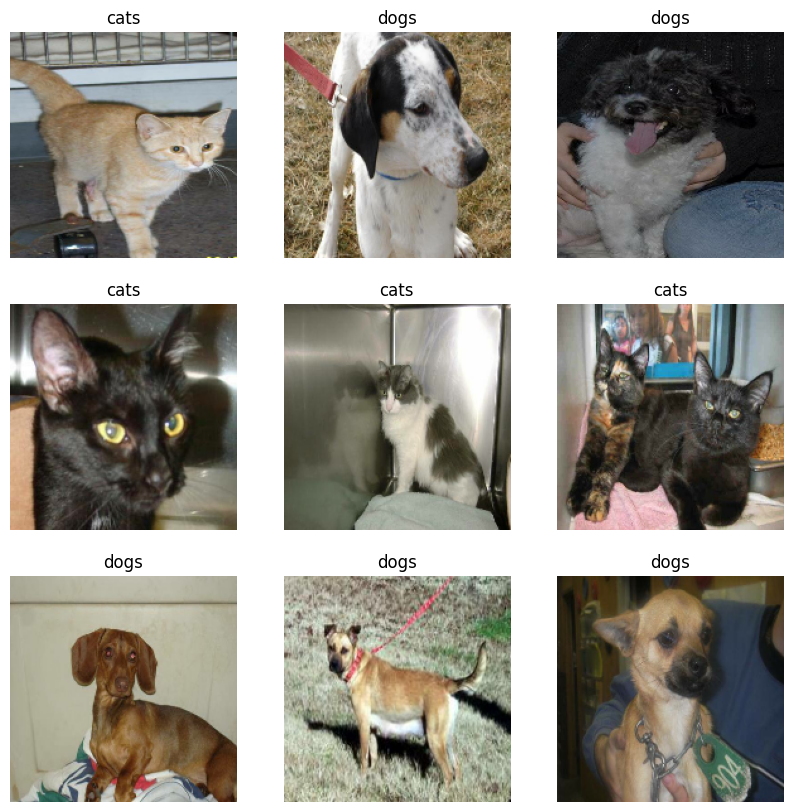

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [51]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance


Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [53]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [58]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.95001143


## Building our CNN for training the cats and dogs dataset

In [75]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model

Using adam optimizer and SparseCategoricalCrossentropy loss

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 64)       

# Train the model

In [78]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 6s 23ms/step - loss: 0.7351 - accuracy: 0.5265 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.6738 - accuracy: 0.5815 - val_loss: 0.6170 - val_accuracy: 0.6670
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.6156 - accuracy: 0.6560 - val_loss: 0.6065 - val_accuracy: 0.6820
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.5485 - accuracy: 0.7260 - val_loss: 0.6853 - val_accuracy: 0.6390
Epoch 5/10
63/63 [==============================] - 1s 13ms/step - loss: 0.4542 - accuracy: 0.7800 - val_loss: 0.5880 - val_accuracy: 0.6990
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.3906 - accuracy: 0.8290 - val_loss: 0.6330 - val_accuracy: 0.6890
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.3093 - accuracy: 0.8705 - val_loss: 0.7497 - val_accuracy: 0.6920
Epoch 8/10
63

# Visualizing training results

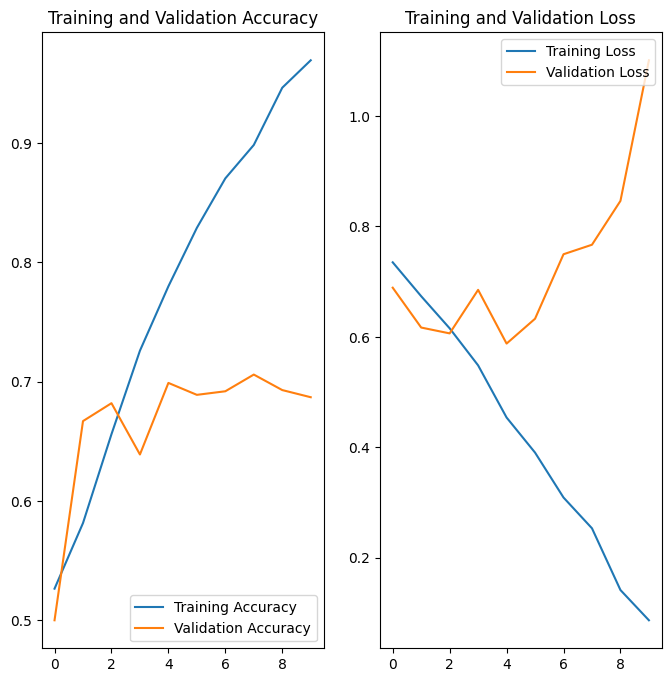

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see, we only get around 65% validation accuracy. After this, we clearly overfit to our training data as our validation accuracy doesn't improve, while our training accuracy does. Our validation loss starts going up steadily while our training loss goes down.

# Data augmentation to address overfitting

We do data augmentation by rotating, zooming and flipping our images horizontally using keras preprocessing. This allows us to greatly increase the size of our dataset functionally. A slightly rotated cat/dog is a new cat or dog to our dataset as far as our model is concerned. This lets us heavily increase the size of our dataset without needing new data.

In [80]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Lets see an example:

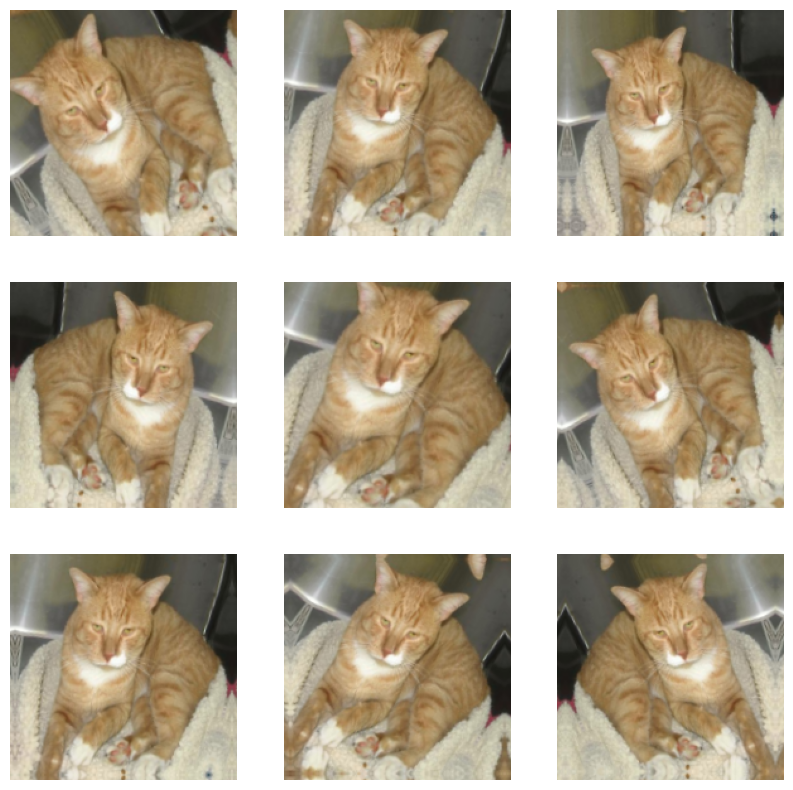

In [81]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Lets also add in dropout to regularize our nn. This can help decrease overfitting by preventing the model from learning our training data exactly.

# Rebuild and train our model

In [82]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                

In [85]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
63/63 [==============================] - 4s 19ms/step - loss: 0.7037 - accuracy: 0.5055 - val_loss: 0.6853 - val_accuracy: 0.6130
Epoch 2/15
63/63 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5465 - val_loss: 0.6819 - val_accuracy: 0.5820
Epoch 3/15
63/63 [==============================] - 1s 16ms/step - loss: 0.6796 - accuracy: 0.5455 - val_loss: 0.7049 - val_accuracy: 0.5760
Epoch 4/15
63/63 [==============================] - 1s 16ms/step - loss: 0.6575 - accuracy: 0.6220 - val_loss: 0.7333 - val_accuracy: 0.5910
Epoch 5/15
63/63 [==============================] - 1s 16ms/step - loss: 0.6201 - accuracy: 0.6750 - val_loss: 0.6347 - val_accuracy: 0.6640
Epoch 6/15
63/63 [==============================] - 1s 16ms/step - loss: 0.6143 - accuracy: 0.6665 - val_loss: 0.6035 - val_accuracy: 0.6800
Epoch 7/15
63/63 [==============================] - 1s 16ms/step - loss: 0.5957 - accuracy: 0.6845 - val_loss: 0.6222 - val_accuracy: 0.6470
Epoch 8/15
63

# Visualizing training results

Lets visualize the results of our data augmentation and dropout.

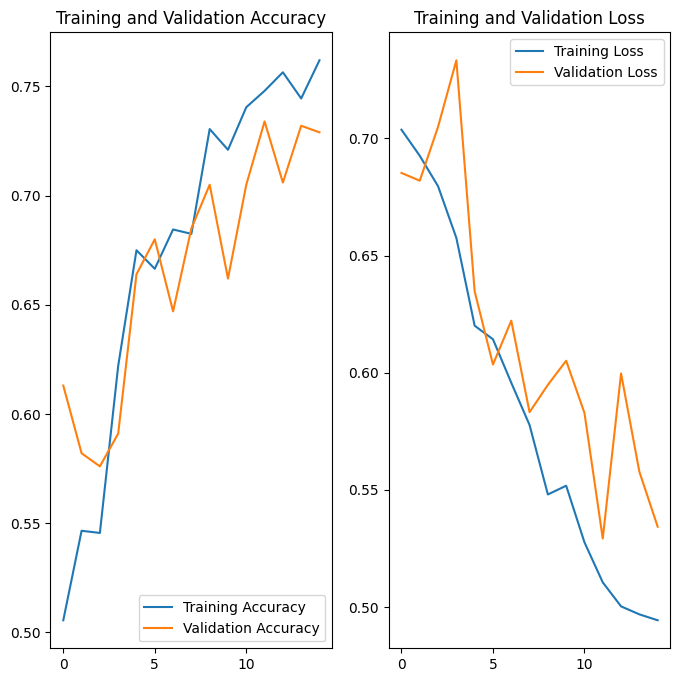

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

MUCH better, validation and training loss and accuracy don't diverge, meaning we aren't overfitting. The overall accuracy we reach is nearly 10% higher as well!